# Population and Customer Clustering

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
%matplotlib inline

In [74]:
title_font_style = {'size': 24, 'weight':'bold'}

### Load Population and Customer Data

In [2]:
population = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')

C:\Users\phornchaiya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
population = population.drop(columns=['LNR'])
population.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\phornchaiya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
customers = customers.drop(columns=['LNR'])

### Data Preprocessing

#### Filling Unknown Values with NaN

In [5]:
missing_val = pd.read_csv("data/missing_value.tsv", sep="\t")
missing_val['unknown_value'] = missing_val['unknown_value'].apply(lambda x: [int(i) for i in x.split(",")])
missing_val.head()

,column_name,unknown_value
0,AGER_TYP,[-1]
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ANREDE_KZ,"[-1, 0]"
3,BALLRAUM,[-1]
4,BIP_FLAG,[-1]


In [6]:
# Replace some values with np.NaN
for idx, row in missing_val.iterrows():
    col_name = row.column_name
    unk_val = row.unknown_value
    
    if col_name not in population.columns :
        continue
    
    population[col_name] = population[col_name].apply(lambda x: np.NaN if x in unk_val else x)
    
    customers[col_name] = customers[col_name].apply(lambda x: np.NaN if x in unk_val else x)

#### Find Portion of Missing Values

In [7]:
count_vals = population.count().reset_index().rename(columns={0:'count'})
count_vals['aval_prop'] = count_vals['count'] / len(population.index.tolist())

In [8]:
count_vals = count_vals.sort_values(['aval_prop'], ascending=False)
count_vals

,index,count,aval_prop
0,LNR,891221,1.000000
78,D19_TELKO_REST,891221,1.000000
91,D19_VERSI_ONLINE_DATUM,891221,1.000000
90,D19_VERSI_OFFLINE_DATUM,891221,1.000000
89,D19_VERSI_DATUM,891221,1.000000
...,...,...,...
4,ALTER_KIND1,81058,0.090952
5,ALTER_KIND2,29499,0.033100
6,ALTER_KIND3,6170,0.006923
349,TITEL_KZ,2160,0.002424


In [ ]:
fig, ax = plt.subplots(figsize=(10, 50))
sns.barplot(data=count_vals, x='aval_prop', y='index', hue='aval_prop', ax=ax)

#### Remove Object Attributes
Since they are not quite helpful

In [9]:
object_cols = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']
for each_col in object_cols:
    print(each_col, population[each_col].nunique(), " values")

CAMEO_DEU_2015 45  values
CAMEO_DEUG_2015 19  values
CAMEO_INTL_2015 43  values
D19_LETZTER_KAUF_BRANCHE 35  values
EINGEFUEGT_AM 5162  values
OST_WEST_KZ 2  values


In [10]:
# from the investigation seems like we should drop all these object columns
population = population.drop(columns=object_cols)
customers = customers.drop(columns=object_cols)

#### Data Imputation using Median 

In [13]:
median_vals = population.median()

In [17]:
population[median_vals.index] = population[median_vals.index].fillna(median_vals)

In [18]:
customers[median_vals.index] = customers[median_vals.index].fillna(median_vals)

#### Scale Input before Clustering

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()
scaler.fit(population)

StandardScaler()

In [21]:
pca_population = scaler.transform(population.sample(frac=0.05, random_state=0))

In [23]:
pd.DataFrame(pca_population).describe()

,0,1,2,3,4,5,6,7,8,9,...,349,350,351,352,353,354,355,356,357,358
count,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,...,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000,44561.000000
mean,-0.003410,-0.006731,-0.002071,0.000705,-0.004190,-0.006674,0.002139,0.000681,0.000651,0.011501,...,-0.003003,-0.006781,-0.007277,-0.005042,-0.004267,0.001482,0.003955,0.000870,-0.009310,0.001436
std,1.001154,1.000070,1.001486,1.014690,1.009563,0.999023,1.042263,0.992046,1.014201,1.181151,...,1.003354,0.998514,0.998257,0.998475,1.003504,0.999363,1.003263,0.998522,1.000380,0.996963
min,-4.941183,-0.942195,-1.503832,-8.059236,-18.311026,-34.795011,-55.422339,-3.231311,-0.528001,-0.118316,...,-2.158238,-1.830744,-2.113773,-1.867551,-1.915448,-3.749833,-2.105348,-1.746456,-1.045218,-1.663024
25%,0.200115,-0.942195,-1.503832,0.018706,0.032972,0.015785,-0.001343,-0.184898,-0.393292,-0.118316,...,-0.329665,-0.732541,-0.505604,-0.735833,-0.688662,0.000652,-0.503428,-0.267936,-1.045218,-0.727373
50%,0.200115,-0.371973,0.266941,0.018706,0.032972,0.015785,-0.001343,0.049442,-0.258584,-0.118316,...,-0.329665,-0.000407,0.137664,0.018645,-0.075268,0.536436,-0.503428,-0.267936,0.956738,0.208278
75%,0.200115,1.338692,0.811794,0.018706,0.032972,0.015785,-0.001343,0.518120,0.078187,-0.118316,...,0.584622,0.731728,0.780932,0.773124,1.151518,0.536436,0.564518,0.471325,0.956738,1.143930
max,2.770764,1.338692,1.356647,4.865471,6.703517,13.069833,33.251254,2.627175,28.434294,58.676930,...,1.498909,1.829930,1.745834,1.904842,1.151518,0.536436,2.166438,1.949845,0.956738,5.822186


#### Identify How Many PCA Dimension Should be Used

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca_data = pd.DataFrame()

for i in range(1, 201):
    pca = PCA(n_components=i)
    pca.fit(pca_population)
    
    pca_data = pca_data.append({'dim': i, 'explained_variance': pca.explained_variance_ratio_, 'total_explained_variance': pca.explained_variance_ratio_.sum()}, ignore_index=True)

In [34]:
pca_data.head()

,dim,explained_variance,total_explained_variance
0,1.0,[0.08106779622388734],0.081068
1,2.0,"[0.08106779622394562, 0.0505001628000574]",0.131568
2,3.0,"[0.08106779622396487, 0.050500162799703624, 0....",0.179100
3,4.0,"[0.0810677962239577, 0.050500162802013145, 0.0...",0.216660
4,5.0,"[0.08106779622397492, 0.05050016280146358, 0.0...",0.239259


Text(0.5, 1.0, 'PCA Dimensions vs Explained Variance')

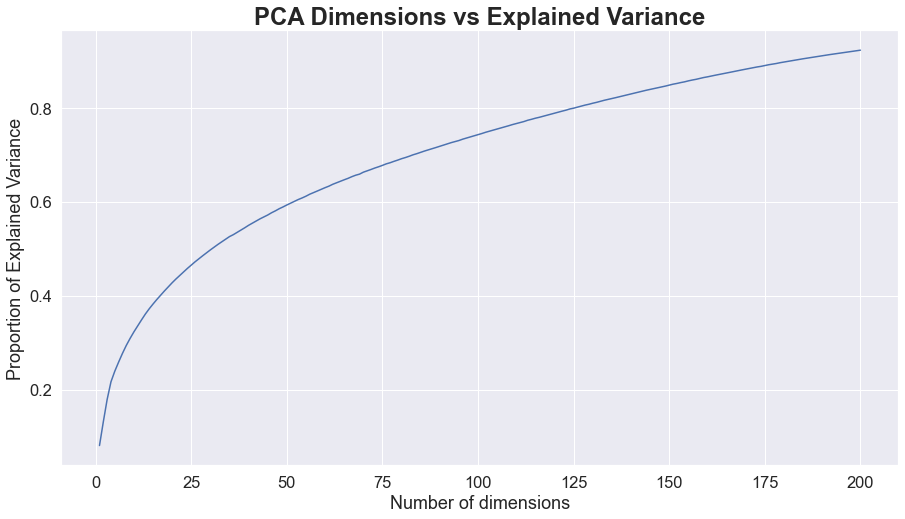

In [46]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=pca_data, x='dim', y='total_explained_variance', ax=ax)
ax.set_xlabel("Number of dimensions")
ax.set_ylabel("Proportion of Explained Variance")
ax.set_title("PCA Dimensions vs Explained Variance", fontdict=title_font_style)

In [38]:
pca_data[pca_data.dim==125]

,dim,explained_variance,total_explained_variance
124,125.0,"[0.08106779622397553, 0.05050016280270411, 0.0...",0.79909


## Do the PCA before Using in Clustering
Since 125 dimensions explained ~80% of population variance, we use this as our desired number of dimensions for do the PCA

In [ ]:
selected_dim_n = 125

pca = PCA(n_components=selected_dim_n)
final_pca_population = pca.fit_transform(scaler.transform(population))

In [49]:
final_pca_customers = pca.fit_transform(scaler.transform(customers[population.columns]))

In [52]:
final_pca_population.shape, final_pca_customers.shape

((891221, 125), (191652, 125))

## Do the Clustering using KMean

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Find How Many Clusters Should be Used using Silhouette Score

In [68]:
pop_size = final_pca_population.shape[0]
np.random.seed(0)
kmean_clustering_train = final_pca_population[np.random.choice(pop_size, size=int(pop_size*0.05), replace=False)]
kmean_clustering_train.shape

(44561, 125)

In [69]:
kmean_score = pd.DataFrame()

for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    cluster_labels = kmeans.fit_predict(kmean_clustering_train)
    
    s_score = silhouette_score(kmean_clustering_train, cluster_labels)
    
    kmean_score = kmean_score.append({'k': i, 'score': s_score, 'inertia': kmeans.inertia_}, ignore_index=True)
    print(f"Finish {i} clusters")

Finish 2 clusters
Finish 3 clusters
Finish 4 clusters
Finish 5 clusters
Finish 6 clusters
Finish 7 clusters
Finish 8 clusters
Finish 9 clusters
Finish 10 clusters
Finish 11 clusters
Finish 12 clusters
Finish 13 clusters
Finish 14 clusters


Text(0.5, 1.0, 'Identifying Number of Clusters using Elbow Method')

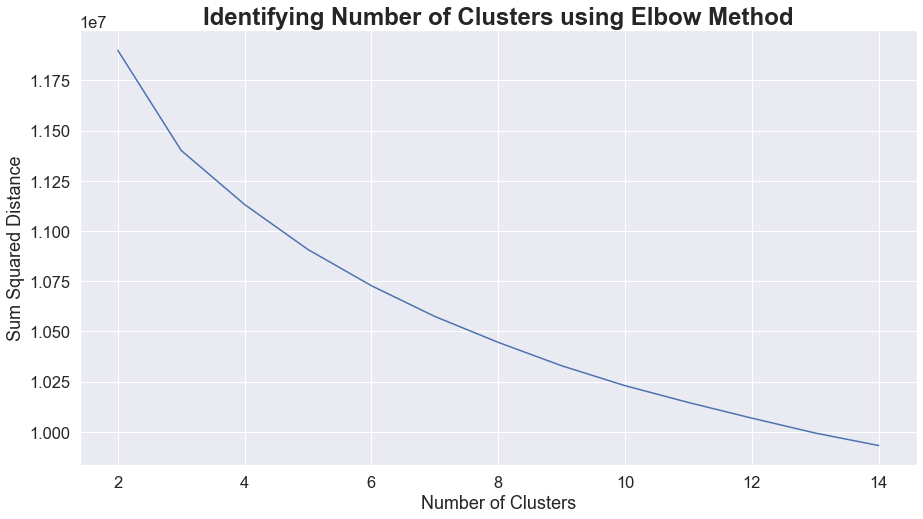

In [76]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=kmean_score, x='k', y='inertia', markers='X', ax=ax)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Sum Squared Distance")

ax.set_title("Identifying Number of Clusters using Elbow Method", fontdict=title_font_style)

Since there is no obvious elbow identify, I use 12 as the number of clusters as number of cluster as they are not too few or too many for the explaination

#### Do the Clustering using K = 12

In [77]:
kmean = KMeans(n_clusters=12, random_state=0)
population_clusters = kmean.fit_predict(final_pca_population)

In [78]:
customers_clusters = kmean.transform(final_pca_customers)

In [81]:
from collections import Counter

In [117]:
pop_clustered = pd.DataFrame.from_dict(Counter(population_clusters), orient='index').reset_index()
pop_clustered.columns = ['cluster', 'occ']
pop_clustered['occ_portion'] = pop_clustered['occ'] / pop_clustered['occ'].sum()
pop_clustered['type'] = 'Population'

In [118]:
cus_clustered = pd.DataFrame.from_dict(Counter(np.argmax(customers_clusters, axis=1)), orient='index').reset_index()
cus_clustered.columns = ['cluster', 'occ']
cus_clustered['occ_portion'] = cus_clustered['occ'] / cus_clustered['occ'].sum()
cus_clustered['type'] = 'Customer'

In [119]:
total_clustered = pop_clustered.append(cus_clustered)

In [120]:
total_clustered

,cluster,occ,occ_portion,type
0,7,79647,0.089368,Population
1,6,113396,0.127237,Population
2,2,101260,0.113619,Population
3,11,36159,0.040572,Population
4,4,64426,0.072290,Population
5,0,103514,0.116149,Population
6,8,101051,0.113385,Population
7,3,76953,0.086346,Population
8,9,53053,0.059528,Population
9,5,63612,0.071376,Population


Text(0.5, 1.0, 'Population and Customers Clustering')

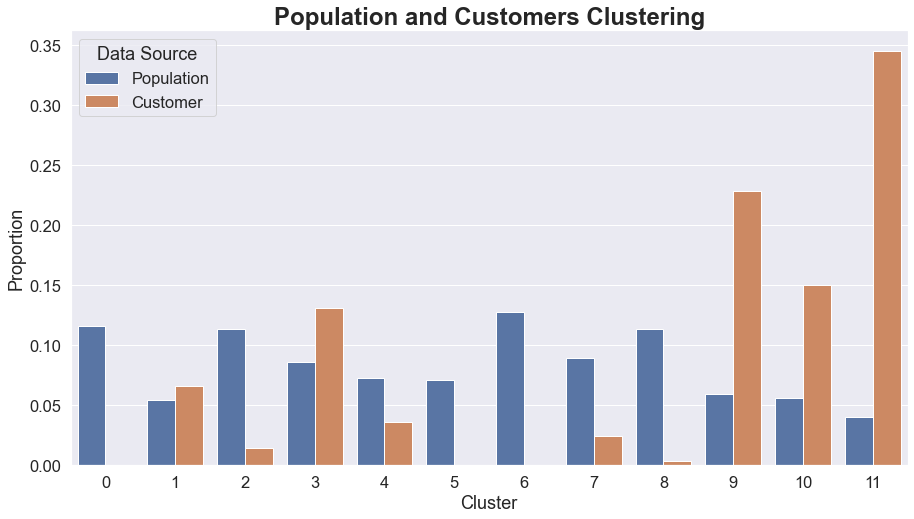

In [135]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.barplot(data=total_clustered, x='cluster', y='occ_portion', hue='type')
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion")
ax.get_legend().set_title("Data Source")

ax.set_title("Population and Customers Clustering", fontdict=title_font_style)
# sns.barplot(data=total_clustered, x='cluster', y='cus_occ_portion')

## Identify Features Represented

In [149]:
features_represented = np.matmul(kmean.cluster_centers_,  pca.components_)

In [154]:
features_name = population.columns.tolist()

In [159]:
pop_portion = np.zeros(features_represented.shape)
for idx, row in pop_clustered.iterrows():
    pop_portion += features_represented[row.cluster] * row.occ_portion

In [171]:
overall_pop_portion = pd.DataFrame.from_dict({'feature': features_name, 'portion': pop_portion.sum(axis=0)})
overall_pop_portion['type'] = 'Population'

In [166]:
cus_portion = np.zeros(features_represented.shape)
for idx, row in cus_clustered.iterrows():
    cus_portion += features_represented[row.cluster] * row.occ_portion

In [172]:
overall_cus_portion = pd.DataFrame.from_dict({'feature': features_name, 'portion': cus_portion.sum(axis=0)})
overall_cus_portion['type'] = 'Customer'

In [173]:
total_portion = overall_pop_portion.append(overall_cus_portion)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 100))
sns.barplot(data=total_portion, x='portion', y='feature', ax=ax)
ax.legend([],[], frameon=False)

#### Calculate Difference between Population and Cluster

In [192]:
diff_pop_cus = pd.DataFrame.from_dict({'feature': features_name, 'diff': cus_portion.sum(axis=0) - pop_portion.sum(axis=0), 'abs_diff': np.abs(cus_portion.sum(axis=0) - pop_portion.sum(axis=0))})
diff_pop_cus = diff_pop_cus.sort_values(['abs_diff'], ascending=False)

In [193]:
diff_pop_cus

,feature,diff,abs_diff
13,ANZ_TITEL,7.353432,7.353432
230,KBA13_HERST_FORD_OPEL,-7.131209,7.131209
180,KBA13_ALTERHALTER_60,-6.948049,6.948049
30,D19_BANKEN_OFFLINE_DATUM,-6.704286,6.704286
222,KBA13_HALTER_55,-6.491519,6.491519
...,...,...,...
46,D19_GESAMT_DATUM,-0.062465,0.062465
348,VHA,-0.050571,0.050571
115,KBA05_ALTER3,-0.035810,0.035810
321,RETOURTYP_BK_S,0.021849,0.021849


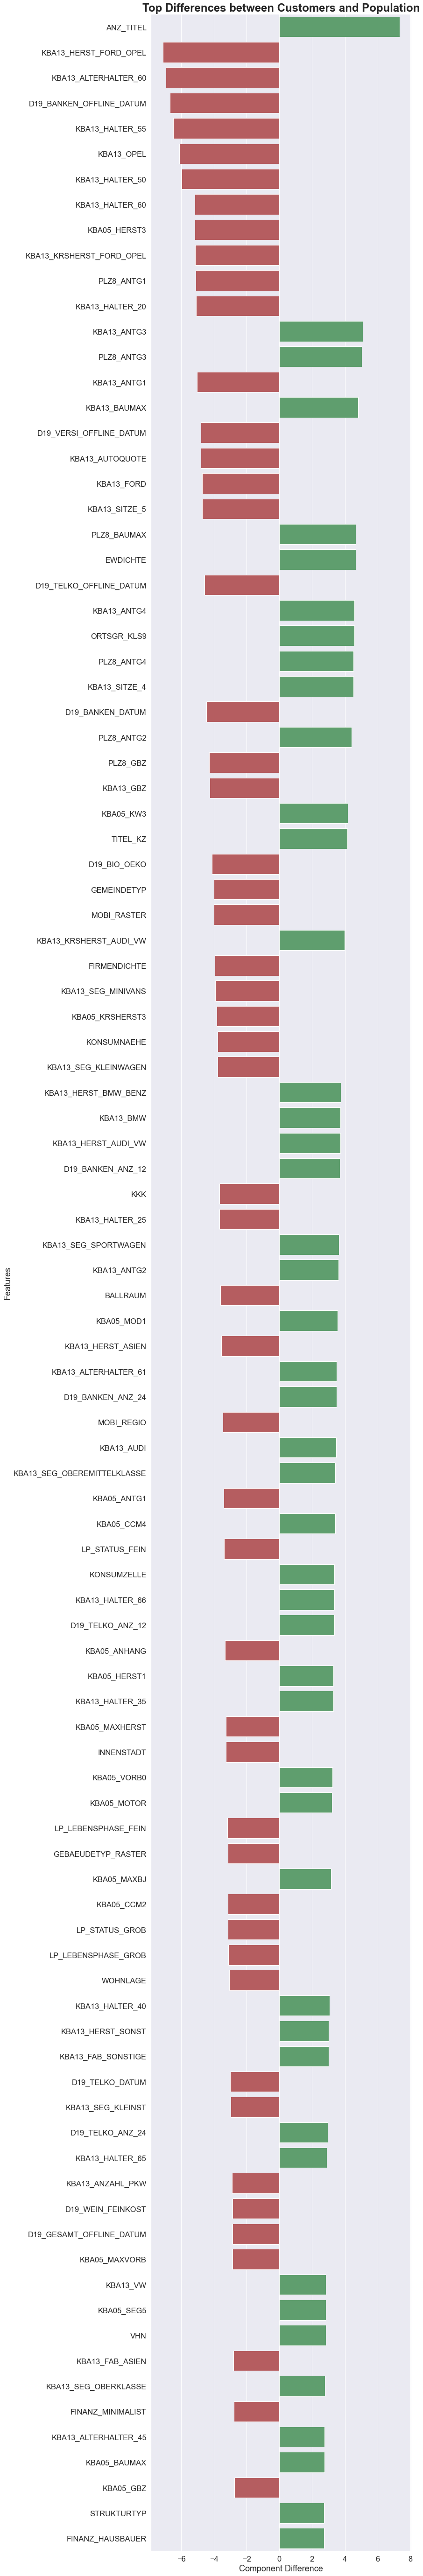

In [200]:
fig, ax = plt.subplots(figsize=(10, 100))
sns.barplot(data=diff_pop_cus.head(100), x='diff', y='feature', ax=ax, palette=(diff_pop_cus['diff'] > 0).map({True: 'g', False: 'r'}))

ax.set_xlabel('Component Difference')
ax.set_ylabel('Features')
ax.set_title('Top Differences between Customers and Population', fontdict=title_font_style)
ax.legend([],[], frameon=False)